# RegularizationAndDropout(Sequential Model)

这里我们使用Sequential Model.

实际上Pytorch的Sequential Model与Keras的Sequential很像可以使用

[1]

```python
model = torch.nn.Sequential(OrderedDict([
        (name,module)
    ]))```

[2]

```python
model = torch.nn.Sequential()
model.add_module(name,module)```

两中形式都可以创建Model,更多详情查看[Sequential](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential)

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable


import numpy as np
from get_data_set import load_data
import matplotlib.pyplot as plt
from Plot_Plot import plot_plot
from miniBatch import random_mini_batche

### Load data


In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [3]:
train_x = train_x_orig.reshape(train_x_orig.shape[0],-1) / 255 
test_x = test_x_orig.reshape(test_x_orig.shape[0],-1) / 255
train_y = train_y.reshape(-1,1)
test_y = test_y.reshape(-1,1)
print('Train_x\'s shape:{}'.format(train_x.shape))
print('Test_x\'s shape:{}'.format(test_x.shape))
print("Train_y's shape:{}".format(train_y.shape))
print("Test_y's shape:{}".format(test_y.shape))

Train_x's shape:(209, 12288)
Test_x's shape:(50, 12288)
Train_y's shape:(209, 1)
Test_y's shape:(50, 1)


In [4]:
from collections import OrderedDict

### Create BL_Sequential and Dropout_Sequential

Dropout_Sequential:使用```model.add_module```的方式.

BL_Sequential:使用```torch.nn.Sequential(OrderedDict([]))```方式.

In [5]:
def BL_Sequential(n):
    """
    create BL Sequential Model.
    Parameters:
    ----------
        n: data set features.
    Return:
    ------
        model: Sequential Model.
    Note:
    ----
        hidden layer: activation function: Relu.
        output layer: activation function: sigmoid.
    """
    torch.manual_seed(1)
    model = torch.nn.Sequential(OrderedDict([
        ('dense1',torch.nn.Linear(n,20)),
        ('relu1',torch.nn.ReLU()),
        ('dense2',torch.nn.Linear(20,7)),
        ('relu2',torch.nn.ReLU()),
        ('dense3',torch.nn.Linear(7,5)),
        ('relu3',torch.nn.ReLU()),
        ('dense4',torch.nn.Linear(5,1)),
        ('sigmoid',torch.nn.Sigmoid())
    ]))
    
    print("Model Sequential:\n>>> ")
    print(model)
    print(">>>")
    return model

In [6]:
def Dropout_Sequential(n):
    """
    create BL Sequential Model.
    Parameters:
    ----------
        n: data set features.
    Return:
    ------
        model: Sequential Model.
    
    Note:
    ----
        drop units is [0.2,0.1,0.]
    """
    torch.manual_seed(1)
    model = torch.nn.Sequential()
    model.add_module('dense1',torch.nn.Linear(n,20))
    model.add_module('relu1',torch.nn.ReLU())
    model.add_module('dropout1',torch.nn.Dropout(p=0.2))
    model.add_module('dense2',torch.nn.Linear(20,7))
    model.add_module('relu2',torch.nn.ReLU())
    model.add_module('dropout2',torch.nn.Dropout(p=0.1))
    model.add_module('dense3',torch.nn.Linear(7,5))
    model.add_module('relu3',torch.nn.ReLU())
    model.add_module('dropout3',torch.nn.Dropout(p=0.))
    model.add_module('dense4',torch.nn.Linear(5,1))
    model.add_module('sigmoid',torch.nn.Sigmoid())
    
    print("Model Sequential:\n>>> ")
    print(model)
    print(">>>")
    return model

### Other function

[1]

```python
def init_weights(m):
    ...```
    
(1.1) 该函数重新设置```nn.Linear()```的weights值,使用Xavier.更多详细查看[stackoverflow](https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch)

(1.2) 使用```model.apply(init_weights)```将其重置,[apply](https://pytorch.org/docs/stable/nn.html#torch.nn.Module.apply)是一个递归将一个```fn```处理.与Python的map函数类似.

[2]

```python
def Change_to_Tensor(data,labels):
    ...```

将我们的数据转换成Tensor,Pytorch才能计算

[3]

```python
def score(model,data,labels,loss_func = None,is_loss=False):
    ....```
    
评分模型函数,需要注意的是需要将模型设置为:```model.eval()```



In [7]:
def init_weights(m):
    """
    rest weigths init value in Linear model.
    parameter:
    ---------
        m: model.
    """
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

In [8]:
def Change_to_Tensor(data,labels):
    """
    Change data to Tensor.
    Parameters:
    ----------
        data: data set.
        labels: data lables.
    Rerurns:
    -------
         data_tensor: type is tensor.
         labels_tensor : type is tensor.
    """
    data_tensor = Variable(torch.Tensor(data)).float()
    labels_tensor = Variable(torch.Tensor(labels)).float()
    
    return data_tensor,labels_tensor 

In [9]:
def score(model,data,labels,loss_func = None,is_loss=False):
    """
    Score model.
    Parameters:
    ----------
        data: score data set.
        labels: score data labels.
        is_loss: caculate loss if it equal ture.
    Rerurns:
    -------
        acc: score data correct rate.
        score_loss: score data loss,if caculate it.
    """
    model.eval()
    m = labels.shape[0]
    out = model.forward(data)
    predict = torch.round(out)
    acc = torch.eq(predict,labels).sum().item() / m
    if is_loss:
        loss = loss_func.forward(out,labels)
        return acc,loss
    else:
        return acc

### Define Pytorch Of Main Function

In [10]:
def main(data,labels,val_data,val_labels,epochs,print_step,lr,batch_size,mode):
    """
    Implement Dropout_Sequential and BL_Sequential.
    Parameters:
    ----------
        data: training data.
        labels: training labels.
        val_data: validatin data.
        val_labels: validation labels.
        epochs: #Iterate.
        print_step: print setp, print loss, training accuracy, validation loss, validation accuracy.
        lr: learning rate.
        batch_size: batch size.
        mode: can choose "BL":Base Lines,"DP":Dropout.
    """
    m,n = data.shape
    # change data/labels to tensor,using score.
    with torch.no_grad():
        data_tensor,labels_tensor = Change_to_Tensor(data,labels)
        val_data_tensor,val_labels_tensor = Change_to_Tensor(val_data,val_labels)
    
    if mode == "BL":
        model = BL_Sequential(n)
    elif mode == "DP":
        model = Dropout_Sequential(n)
    
    # reset weights in Linear model.
    model.apply(init_weights)
    
    # build loss function
    loss_func = torch.nn.BCELoss()
    # build optimizer
    optimizer = torch.optim.SGD(model.parameters(),lr=lr)
    
    seed = 0
    train_loss = []
    acc_trains = []
    val_losss = []
    acc_vals = []
    
    # start training.
    for epoch in range(epochs):
        model.train()
        seed += 1
        batchs = random_mini_batche(X=data,Y=labels,mini_batche_size=batch_size,seed=seed)
        for mini_x,mini_y in batchs:
           
            mini_x_tensor,mini_y_tensor = Change_to_Tensor(mini_x,mini_y)
            # start forward
            out = model.forward(mini_x_tensor)
            # caculate loss
            loss = loss_func.forward(out,mini_y_tensor)
            # backward
            optimizer.zero_grad()
            loss.backward()
            # updating
            optimizer.step()
            
        if epoch % print_step == 0:
            acc_train = score(model,data_tensor,labels_tensor)
            acc_val,val_loss = score(model,val_data_tensor,val_labels_tensor,loss_func,True)
            print('[{}/{}] loss:{},acc train:{},val loss:{},acc val:{}'.format(epoch+print_step,
                                                                              epochs,
                                                                              loss,
                                                                              acc_train,
                                                                              val_loss,
                                                                              acc_val))
            train_loss.append(loss)
            acc_trains.append(acc_train)
            val_losss.append(val_loss)
            acc_vals.append(acc_val) 
            
    return train_loss,acc_trains,val_losss,acc_vals

### Testing Base Lines
以下的测试参数,可能不是模型的最优参数,我们这里只是为了做对比,只更改必要参数,像epochs,lr,等我们都不会进行更改.

In [11]:
train_loss,acc_trains,val_losss,acc_vals = main(data=train_x,labels=train_y,val_data=test_x,
                                                               val_labels=test_y,epochs=1000,print_step=100,
                                                                lr=0.01,batch_size=64,mode="BL")

Model Sequential:
>>> 
Sequential(
  (dense1): Linear(in_features=12288, out_features=20, bias=True)
  (relu1): ReLU()
  (dense2): Linear(in_features=20, out_features=7, bias=True)
  (relu2): ReLU()
  (dense3): Linear(in_features=7, out_features=5, bias=True)
  (relu3): ReLU()
  (dense4): Linear(in_features=5, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
>>>
[100/1000] loss:0.6947056651115417,acc train:0.6555023923444976,val loss:0.7043969035148621,acc val:0.34
[200/1000] loss:0.6115889549255371,acc train:0.6555023923444976,val loss:0.7640635967254639,acc val:0.34
[300/1000] loss:0.37539419531822205,acc train:0.8755980861244019,val loss:0.6347540020942688,acc val:0.66
[400/1000] loss:0.19854626059532166,acc train:0.9234449760765551,val loss:0.5526072978973389,acc val:0.78
[500/1000] loss:0.15015943348407745,acc train:0.9952153110047847,val loss:0.6562045216560364,acc val:0.7
[600/1000] loss:0.11940088123083115,acc train:0.9952153110047847,val loss:0.7841079831123352,acc val:0.68

我们看到这里显示出来的Sequential是与```nn.Module```创建出来的不同

![](../../../picture/66.png)

在Sequential中,我们已经加入Relu函数,而在```nn.Module```中实际上我们是在forward的时候才调用,两者都有各自的好处,如果你想多在forward中加入一些自定义内容,那么可以采取```nn.Module```的形式,如果你无需做那么多其他操作,那么使用```nn.Module```Sequential会更加方便.

详情查看[莫烦Pytorch](https://www.pytorchtutorial.com/3-3-sequential-cnn-model/)

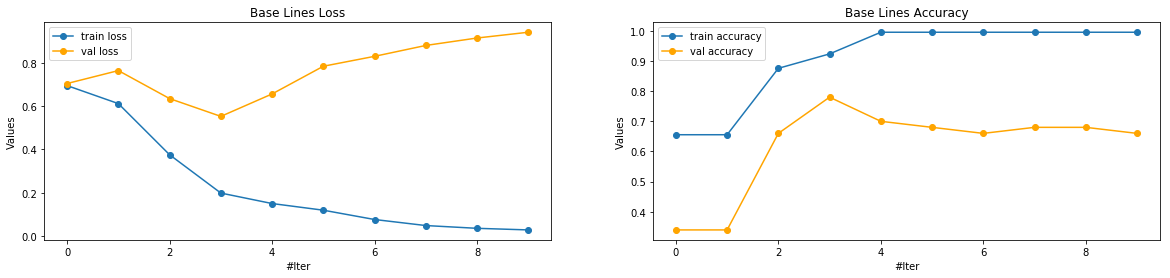

In [12]:
plot_plot(train_loss,acc_trains,acc_vals,val_losss,method='Base Lines')

### Dropout

In [13]:
train_loss,acc_trains,val_losss,acc_vals = main(data=train_x,labels=train_y,val_data=test_x,
                                                               val_labels=test_y,epochs=500,print_step=50,
                                                                lr=0.1,batch_size=64,mode="DP")

Model Sequential:
>>> 
Sequential(
  (dense1): Linear(in_features=12288, out_features=20, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2)
  (dense2): Linear(in_features=20, out_features=7, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.1)
  (dense3): Linear(in_features=7, out_features=5, bias=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.0)
  (dense4): Linear(in_features=5, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
>>>
[50/500] loss:0.6978746652603149,acc train:0.6555023923444976,val loss:0.7217110395431519,acc val:0.34
[100/500] loss:0.6911508440971375,acc train:0.6555023923444976,val loss:0.8384591937065125,acc val:0.34
[150/500] loss:0.6430980563163757,acc train:0.6555023923444976,val loss:0.7083554267883301,acc val:0.34
[200/500] loss:0.4662562608718872,acc train:0.6555023923444976,val loss:0.9535783529281616,acc val:0.34
[250/500] loss:0.6631075143814087,acc train:0.6555023923444976,val loss:0.7195003628730774,acc val:0.34
[300/500] loss:0.448695898

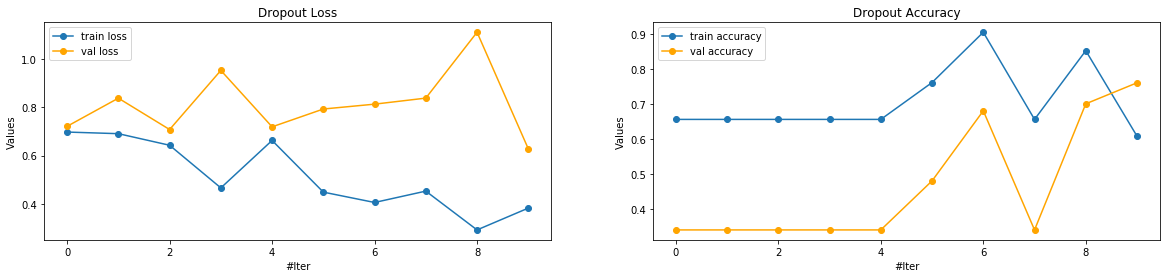

In [14]:
plot_plot(train_loss,acc_trains,acc_vals,val_losss,method='Dropout')

可以看到效果有所改善,最好的值大约在9个epoch,train/validation correct rate最接近.

### Summary

实际上采用Sequential模式还是```nn.Module```模式,依照不同情况选择不同的方式.